In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import json

import os
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments')

from helpers.trainer import Trainer
from helpers.train_all import TrainerAll

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def whitening_transform(data):
    # Center the data (subtract mean)
    mean = torch.mean(data, dim=0, keepdim=True)
    centered_data = data - mean

    # Compute covariance matrix
    covariance_matrix = torch.matmul(centered_data.T, centered_data) / (centered_data.size(0) - 1)

    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = torch.eig(covariance_matrix, eigenvectors=True)

    # Whitening transformation
    whitened_data = torch.matmul(torch.matmul(eigenvectors, torch.diag(1 / torch.sqrt(eigenvalues[:, 0]))), eigenvectors.T) @ centered_data.T
    
    return whitened_data.T

In [4]:
# Defining batch size as given on page 7 on Adam Research Paper
batch_size = 128    

# Calculate the number of workers to use for DataLoader
num_workers = 8

# transformations
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments/models')

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='../../datasets/', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../../datasets/', train=False, download=True, transform=transform)

# trainset = whitening_transform(trainset)
# testset = whitening_transform(testset)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)  # 3 input channels, 64 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2) # 64 input channels, 64 output channels, 5x5 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2) # 64 input channels, 128 output channels, 5x5 kernel

        self.fc1 = nn.Linear(128 * 3 * 3, 1000)  # 128 * 4 * 4 input features, 1000 output features
        self.fc2 = nn.Linear(1000, 10)  # 1000 input features, 10 output classes
        
    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        # Flatten the feature maps
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))

        
        # Output layer with softmax activation
        x = self.fc2(x)
        # x = F.log_softmax(x, dim=1)

        return x


In [7]:
criterion = nn.CrossEntropyLoss()
epochs = 200

optimizer = optim.Adam

In [8]:
model = CNN().to(device)
trainer = TrainerAll(train_loader, test_loader, criterion, epochs=50)

head1, head2, head3 = 'EPOCHS', 'TRAIN LOSS', 'VAL LOSS'
print(f'{head1 :>6} {head2 :>25} {head3 :>25}')

log = trainer.train_all_optim(model)

EPOCHS                TRAIN LOSS                  VAL LOSS
Optimizer : Adam_custom


    10        1.1102600254671042        1.1582110320465475
    20        0.8993112713174747         1.161731612078751
    30        0.9061569228501576        1.8987472766562352
    40        0.7978719966986295        2.8974545696113685
    50        0.7797643486839121         5.267354750935035
Optimizer : Adam_torch
    10       0.32333997776136375        0.9055070492285716
    20       0.09563385356036598        1.6329560023319871
    30        0.0700063169779032        1.9550483392763742
    40       0.06397357443764405         2.246337111992172
    50        0.0556404029514612        2.5493693019770367
Optimizer : RMS_torch
    10       0.37565138013771426        0.9448704493196705
    20       0.10555954542620789        1.8824734521817557
    30       0.07634227023438533         2.395819270158116
    40       0.06957945643800317        2.8981907986387423
    50       0.07076538206093594         3.387591808657103
Optimizer : AdaGrad_torch
    10         1.067556402719844        1.08

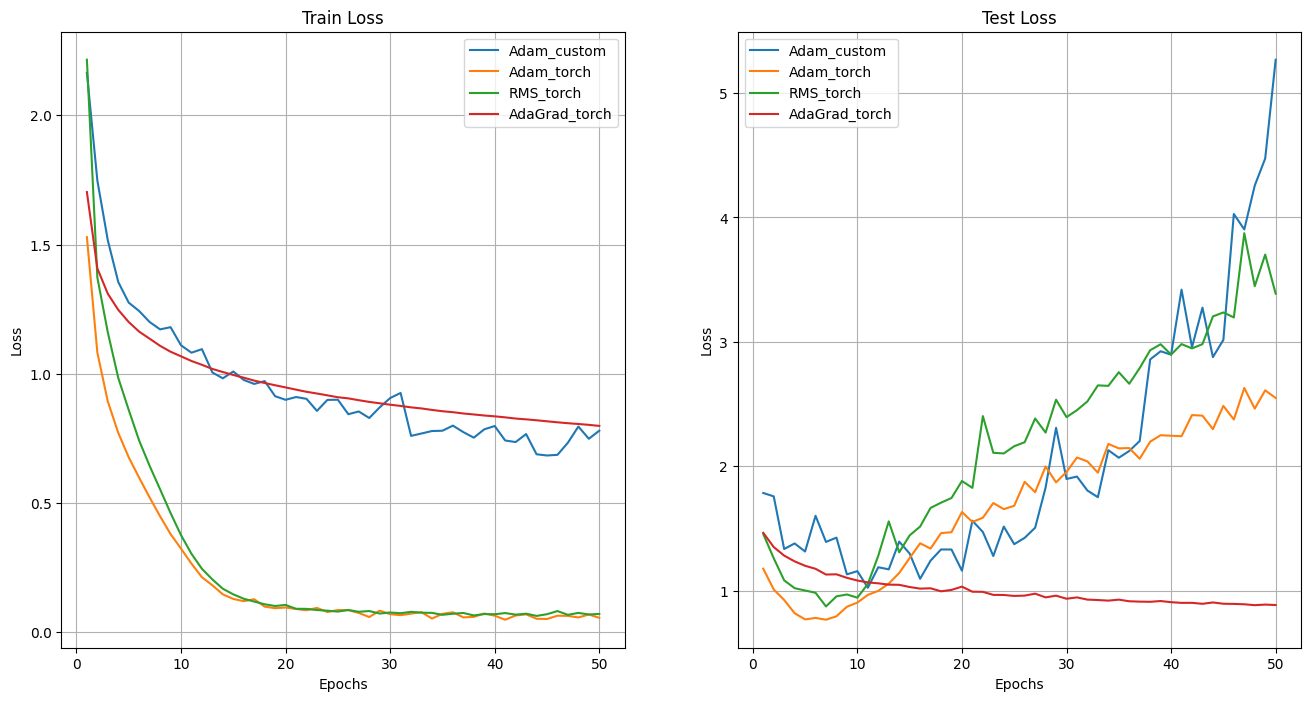

In [9]:
trainer.plot_loss_graphs()

In [10]:
import json

with open('../results/logs/CIFAR_CNN.json', 'w', encoding ='utf8') as file: 
    json.dump(log, file, ensure_ascii = False, indent=4) 

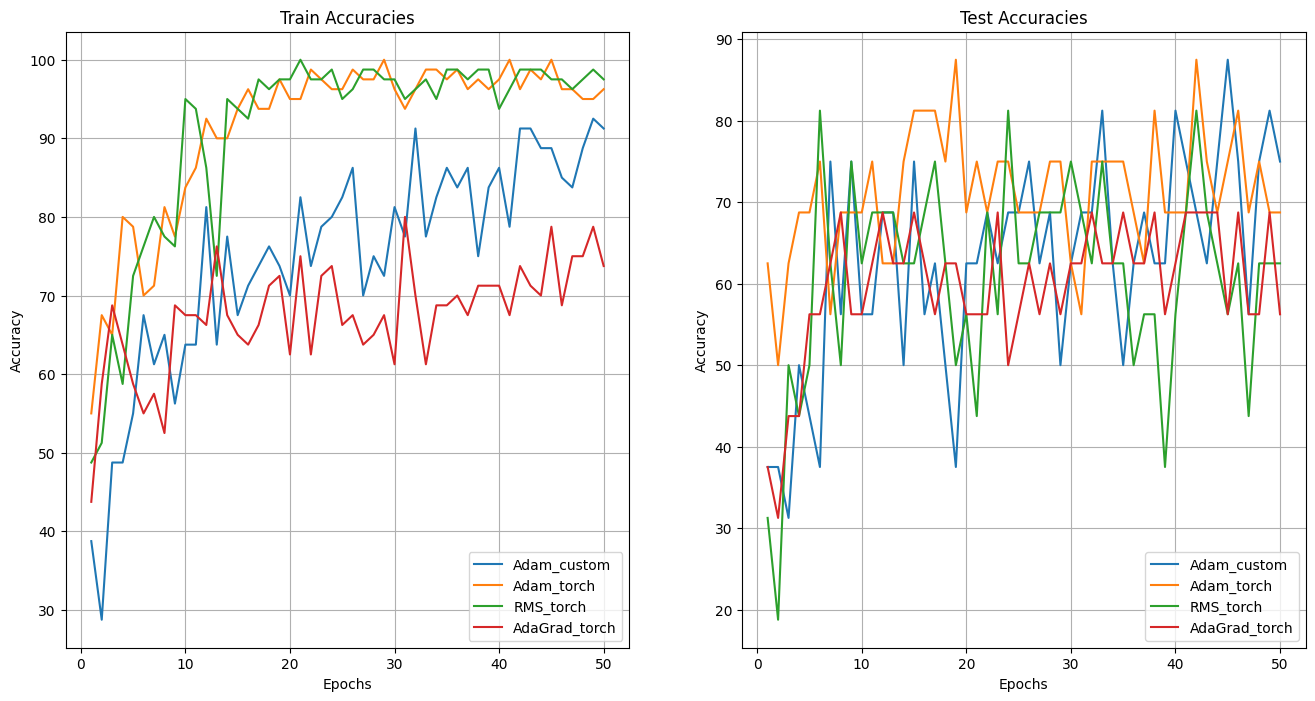

In [11]:
trainer.plot_acc_graphs()